# 3D-deconvolution with prior learned GAN

## create deconvolution model
tf.fft_shift needs even number of dims, so eventually cut an array (then create new otf)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
from glob import glob
from skimage import io
import json 
import pprint
from keras import optimizers, losses

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, './scripts')

import helper as hp
import deconvolution
from NanoImagingPack.microscopy import PSF3D
from NanoImagingPack.view import view

import warnings
warnings.filterwarnings("ignore")

#### load and image, GAN model, reconstruct the OTF and create deconvolution model 

In [7]:
day = '2018_12_7'
filename_D = '09_05_37_disc'
filename_G = '09_05_39_gene'
# filename_C = '13_53_02_combined'

generator = hp.model_loader(day, filename_G)
discriminator = hp.model_loader(day, filename_D)
# combined = hp.model_loader(day, filename_C)

file: ./models/2018_12_7/09_05_39_gene.h5
Loaded model from disk
file: ./models/2018_12_7/09_05_37_disc.h5
Loaded model from disk


In [3]:
# with open('./models/{0}/hyperparameter_13_52_55.json'.format(day)) as json_data:
#     json_file = json.load(json_data)
#     otf_info = json_file['OTF']
#     hparam = json_file['hyper_parameter']
#     pprint.pprint(otf_info)
#     pprint.pprint(hyperparameter)
    
# vol_original = (hparam['RESIZE']['width'],
#                 hparam['RESIZE']['height'],
#                 hparam['RESIZE']['depth'])   

vol_original = (64,64,32)

# CAUTION: OTF is already shifted
otf = PSF3D(im=(64,64,32))
# otf = PSF3D(im=vol_original,
#             NA=otf_info['NA'],
#             wavelength=otf_info['wavelength'],
#             ret_val=otf_info['ret_val'])

otf = otf/np.max(np.abs(otf))
otf = np.fft.fftshift(otf)

otf.shape

(64, 64, 32)

In [5]:
# adam = optimizers.Adam(hparam['ADAM_OPTIMIZER_LEARNRATE'], 0.5)

# discriminator.compile(loss=hparam['D_LOSS'], optimizer=adam, metrics=['accuracy'])
# combined.compile(loss=hparam['COMBINED_LOSS'], loss_weights=hparam['LOSS_WEIGHTS'], optimizer=adam)
# generator.compile(loss='mae', optimizer=adam)

In [4]:
# load an image

# v_path = np.random.choice(glob('./data/3D/dub/*'), size=1)[0]
v_path = './data/3D/dub\dub80.tif'
print(v_path)
vol = np.swapaxes(io.imread(v_path), 0, 2)/127.5 - 1.
print(vol.shape)
vol = hp.cut_volume(vol, vol_original)
print(vol.shape,'\t', np.min(vol),'\t', np.max(vol))

./data/3D/dub\dub80.tif
(768, 512, 33)
(64, 64, 32) 	 -1.0 	 0.4980392156862745


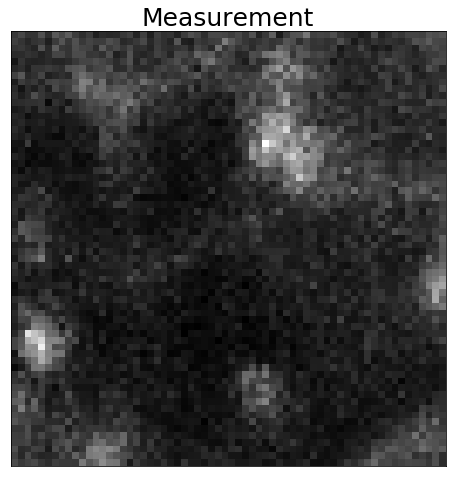

In [5]:
f = plt.figure(figsize=(12,8))
plt.imshow(np.max(vol, axis=2), cmap='gray', interpolation='none'); 
plt.xticks([])
plt.yticks([])
plt.title('Measurement', fontsize=25)
plt.show()

In [8]:
%%time

# execute prediction with generator
t = np.expand_dims(np.expand_dims(vol, axis=0), axis=-1)
x = generator.predict(t).squeeze()

Wall time: 1min 56s


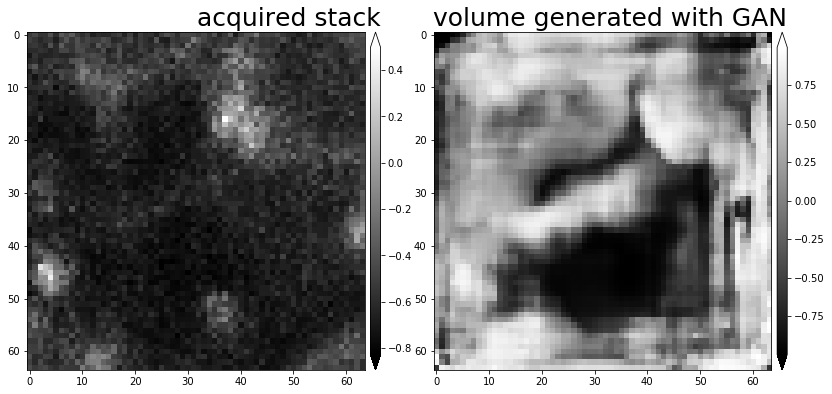

In [9]:
f = plt.figure(figsize=(12,8))
plt.subplot(121); 
temp = plt.imshow(np.max(t.squeeze(), axis=2), cmap='gray', interpolation='none'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('acquired stack', fontsize=25, loc='right');
plt.subplot(122); 
temp = plt.imshow(np.max(x, axis=2), cmap='gray', interpolation='none'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('volume generated with GAN', fontsize=25, loc='right')
plt.subplots_adjust(left=0.02, wspace=0.15, top=0.92)
plt.show()

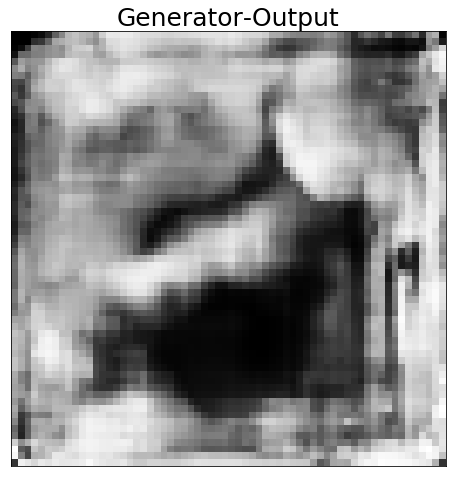

In [15]:
f = plt.figure(figsize=(12,8))
plt.imshow(np.max(x, axis=2), cmap='gray', interpolation='none'); 
plt.xticks([])
plt.yticks([])
plt.title('Generator-Output', fontsize=25)
plt.show()

In [13]:
# check shapes for deconvolution model
# CAUTION: check if the axes of vol must be swaped
#     if yes: swap it, before commit it to the deconvolution-model

print('vol:\t', vol.shape)
print('otf:\t', otf.shape)
print('x\t', x.shape)

print(np.min(vol), np.max(vol))

vol:	 (64, 64, 32)
otf:	 (64, 64, 32)
x	 (64, 64, 32)
-1.0 -0.28627450980392155


In [52]:
# release GPU
import gc

gc.collect()

47519

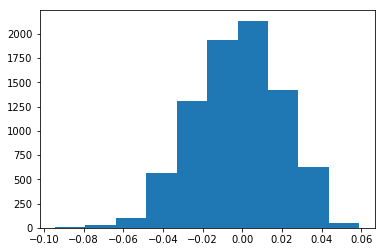

In [34]:
# print(generator.layers)
t = generator.layers[-2].get_weights()[0].squeeze()
plt.hist(t.flatten())
plt.show()

## declare iterative Deconvolution model and build graph


Successfully build tensorflow-graph for iterative Deconvolution



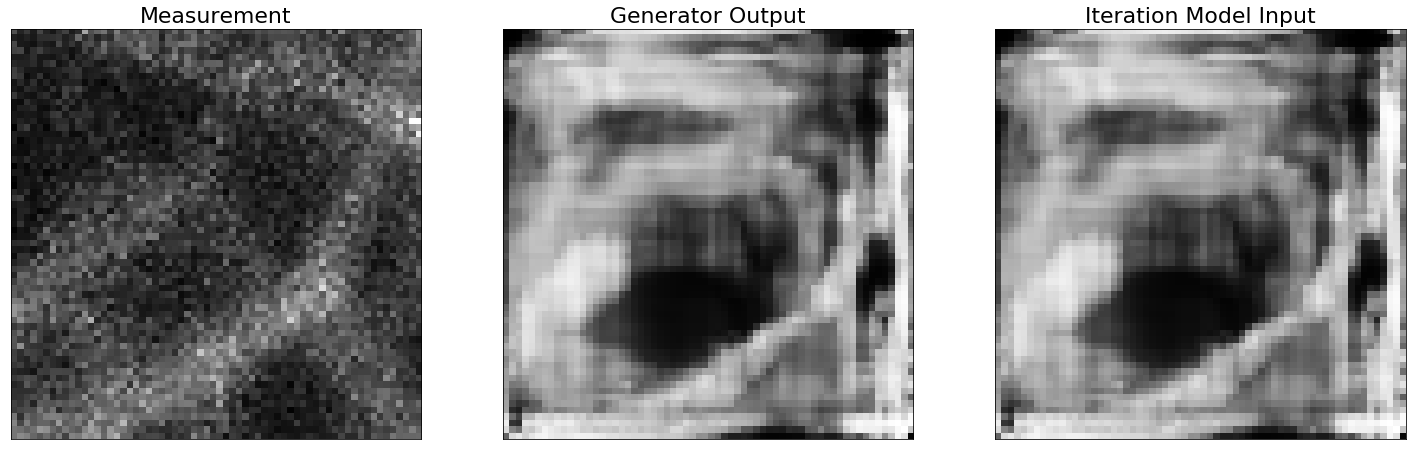

epoch: 0 ,	loss: 61.69987106323242 , D: 0.16899999976158142 ,variance: 0.14000000059604645


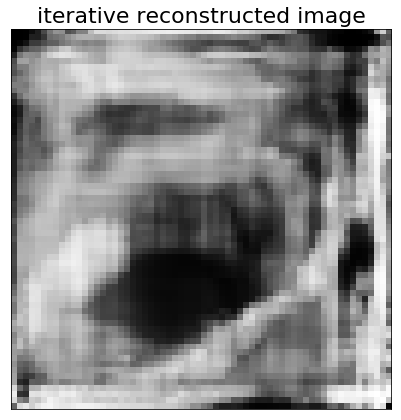

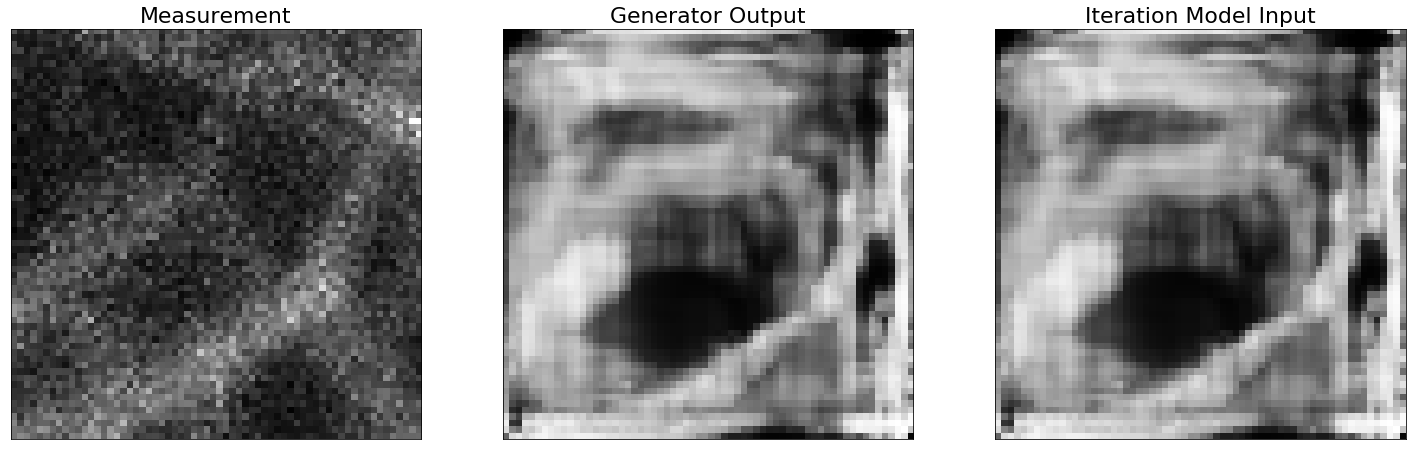

epoch: 10 ,	loss: 61.334049224853516 , D: 0.16899999976158142 ,variance: 0.13899999856948853
epoch: 20 ,	loss: 60.97003173828125 , D: 0.16899999976158142 ,variance: 0.13899999856948853
epoch: 30 ,	loss: 60.60782241821289 , D: 0.16899999976158142 ,variance: 0.1379999965429306
epoch: 40 ,	loss: 60.24748229980469 , D: 0.16899999976158142 ,variance: 0.1379999965429306
epoch: 50 ,	loss: 59.88892364501953 , D: 0.16899999976158142 ,variance: 0.13699999451637268
epoch: 60 ,	loss: 59.532264709472656 , D: 0.16899999976158142 ,variance: 0.13699999451637268
epoch: 70 ,	loss: 59.17744064331055 , D: 0.16899999976158142 ,variance: 0.13600000739097595
epoch: 80 ,	loss: 58.8245735168457 , D: 0.16899999976158142 ,variance: 0.13600000739097595
epoch: 90 ,	loss: 58.47356033325195 , D: 0.16899999976158142 ,variance: 0.13500000536441803
epoch: 100 ,	loss: 58.12446975708008 , D: 0.16899999976158142 ,variance: 0.13500000536441803
epoch: 110 ,	loss: 57.777320861816406 , D: 0.16899999976158142 ,variance: 0.1340

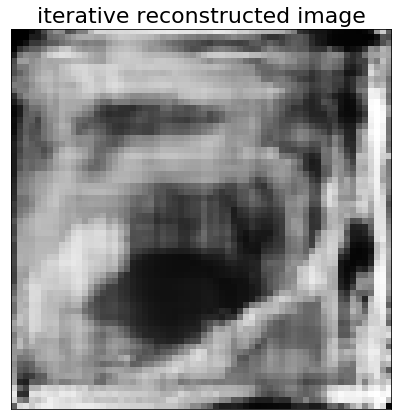

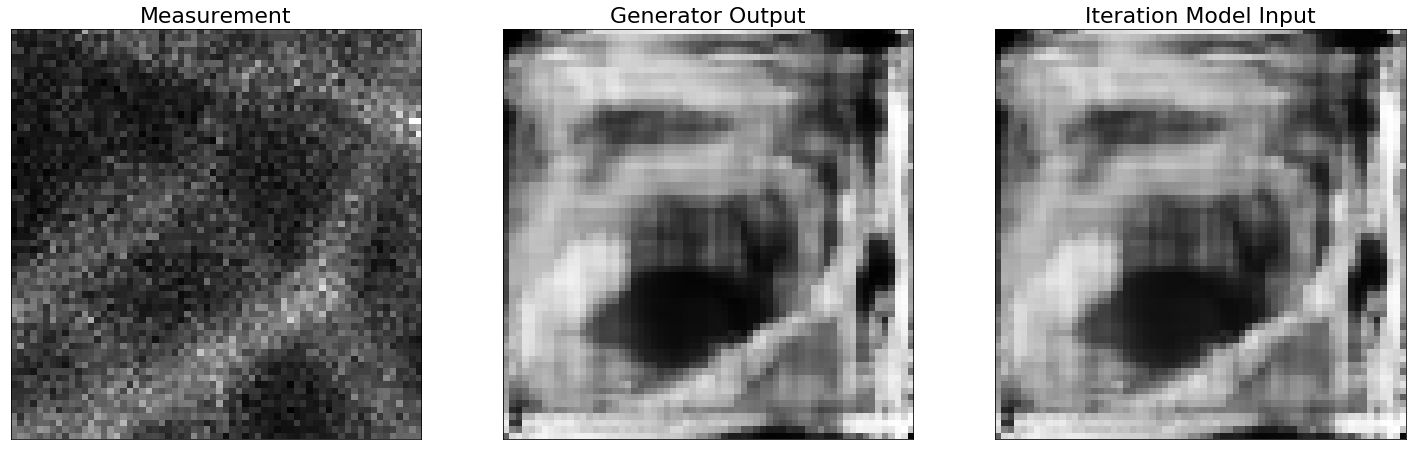

epoch: 260 ,	loss: 52.81108856201172 , D: 0.16899999976158142 ,variance: 0.12700000405311584
epoch: 270 ,	loss: 52.496681213378906 , D: 0.16899999976158142 ,variance: 0.12700000405311584
epoch: 280 ,	loss: 52.184425354003906 , D: 0.16899999976158142 ,variance: 0.12600000202655792
epoch: 290 ,	loss: 51.87433624267578 , D: 0.1679999977350235 ,variance: 0.12600000202655792
epoch: 300 ,	loss: 51.56644058227539 , D: 0.1679999977350235 ,variance: 0.12600000202655792
epoch: 310 ,	loss: 51.26072311401367 , D: 0.1679999977350235 ,variance: 0.125
epoch: 320 ,	loss: 50.95722198486328 , D: 0.1679999977350235 ,variance: 0.125
epoch: 330 ,	loss: 50.655914306640625 , D: 0.1679999977350235 ,variance: 0.12399999797344208
epoch: 340 ,	loss: 50.35685729980469 , D: 0.1679999977350235 ,variance: 0.12399999797344208
epoch: 350 ,	loss: 50.05998611450195 , D: 0.1679999977350235 ,variance: 0.12399999797344208
epoch: 360 ,	loss: 49.76538848876953 , D: 0.1679999977350235 ,variance: 0.12300000339746475
epoch: 370

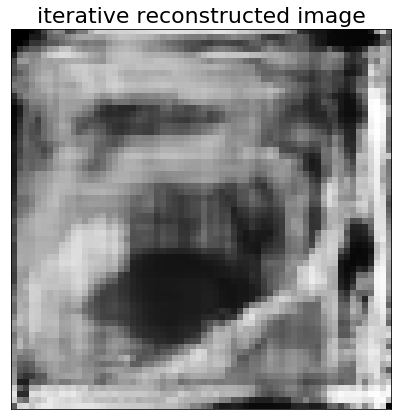

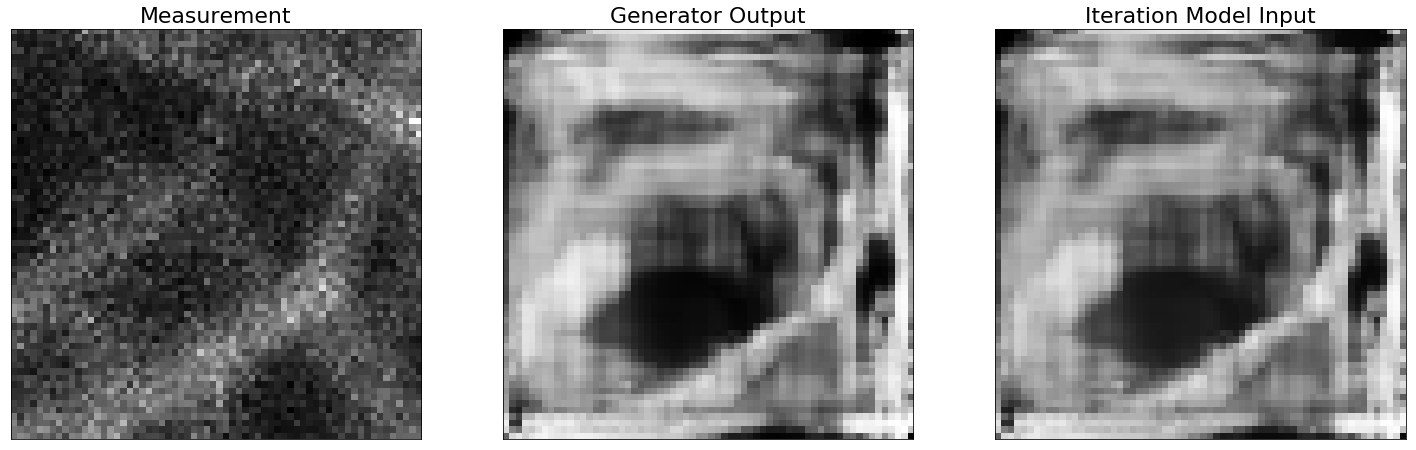

epoch: 510 ,	loss: 45.62173080444336 , D: 0.1679999977350235 ,variance: 0.11800000071525574
epoch: 520 ,	loss: 45.3641471862793 , D: 0.1679999977350235 ,variance: 0.11699999868869781
epoch: 530 ,	loss: 45.10897445678711 , D: 0.1679999977350235 ,variance: 0.11699999868869781
epoch: 540 ,	loss: 44.85613250732422 , D: 0.1679999977350235 ,variance: 0.11699999868869781
epoch: 550 ,	loss: 44.605674743652344 , D: 0.1679999977350235 ,variance: 0.11599999666213989
epoch: 560 ,	loss: 44.35759735107422 , D: 0.1679999977350235 ,variance: 0.11599999666213989
epoch: 570 ,	loss: 44.11190414428711 , D: 0.1679999977350235 ,variance: 0.11599999666213989
epoch: 580 ,	loss: 43.86858367919922 , D: 0.1679999977350235 ,variance: 0.11500000208616257
epoch: 590 ,	loss: 43.627647399902344 , D: 0.1679999977350235 ,variance: 0.11500000208616257
epoch: 600 ,	loss: 43.38908004760742 , D: 0.1679999977350235 ,variance: 0.11500000208616257
epoch: 610 ,	loss: 43.15289306640625 , D: 0.1679999977350235 ,variance: 0.11400

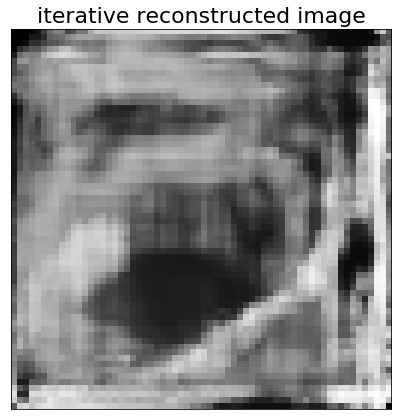

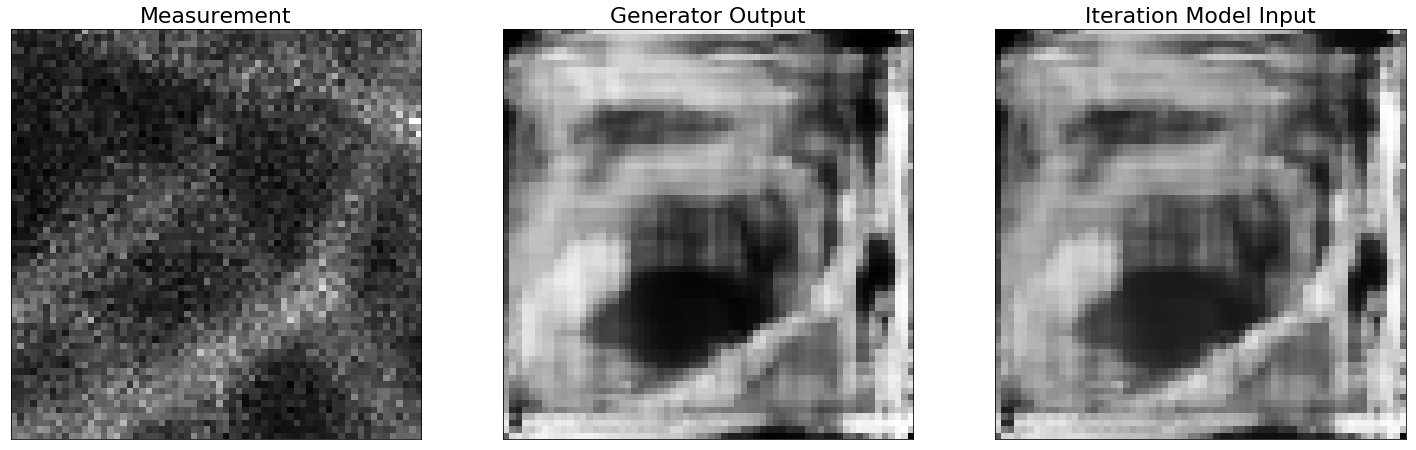

epoch: 760 ,	loss: 39.89475631713867 , D: 0.1679999977350235 ,variance: 0.10999999940395355
epoch: 770 ,	loss: 39.696327209472656 , D: 0.1679999977350235 ,variance: 0.10999999940395355
epoch: 780 ,	loss: 39.50019073486328 , D: 0.1679999977350235 ,variance: 0.10899999737739563
epoch: 790 ,	loss: 39.30636978149414 , D: 0.1679999977350235 ,variance: 0.10899999737739563
epoch: 800 ,	loss: 39.11482238769531 , D: 0.1679999977350235 ,variance: 0.10899999737739563
epoch: 810 ,	loss: 38.92557144165039 , D: 0.1679999977350235 ,variance: 0.1080000028014183
epoch: 820 ,	loss: 38.73859405517578 , D: 0.1679999977350235 ,variance: 0.1080000028014183
epoch: 830 ,	loss: 38.55387496948242 , D: 0.1679999977350235 ,variance: 0.1080000028014183
epoch: 840 ,	loss: 38.37139129638672 , D: 0.1679999977350235 ,variance: 0.1080000028014183
epoch: 850 ,	loss: 38.191158294677734 , D: 0.1679999977350235 ,variance: 0.10700000077486038
epoch: 860 ,	loss: 38.013145446777344 , D: 0.1679999977350235 ,variance: 0.1070000

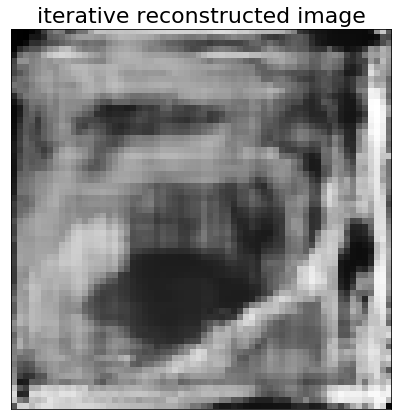

Wall time: 1h 21min 10s


In [47]:
%%time

model = deconvolution.Deconvolution_3D(vol=vol, 
                                        otf=otf,
                                        generator=generator,
                                        discriminator=discriminator,
                                        lam_TV=0 ,
                                        lam_GAN=1.,
                                        plot_init=True)

model.optimize(epochs=1000)

Tensor("add:0", dtype=float32)
0 [-0.21999997] [-0.456]
50 [-0.7127021] [0.15530905]
100 [-0.84270465] [0.5375326]
150 [-0.913881] [0.74679965]
200 [-0.9528499] [0.86137295]


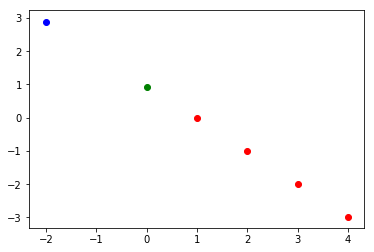

In [4]:
import tensorflow as tf

# Model parameters
W = tf.Variable([.3], tf.float32)
b = tf.Variable([-.3], tf.float32)
# Model input and output
x = tf.placeholder(tf.float32)
linear_model = W * x + b
y = tf.placeholder(tf.float32)
# loss
loss = tf.reduce_sum(tf.square(linear_model - y)) # sum of the squares
# optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)
# training data
x_train = [1,2,3,4]
y_train = [0,-1,-2,-3]
# training loop
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) # reset values to wrong
print(linear_model)
for i in range(250):
    r = sess.run([train, W, b], {x:x_train, y:y_train})
    if i % 50 == 0:
        print(i, r[1], r[2])
    
    
plt.scatter(x_train, y_train, color='red')
plt.scatter([0.], r[2], color='green')
plt.scatter([-2.], r[1]*-2.+r[2] , color='blue')
plt.show()

## train/iterate model

In [55]:
model.optimize(epochs=3)

loss: 1153252.875
loss: -1329872764928.0
loss: -2659746578432.0


## Test the FT-convolution with tensorflow

In [34]:
# Lets just try to convolve a point like object to get an idea of the PSF

# generate an object with exactly one zero element
myobject = np.zeros(otf.shape)
m_w, m_h, m_d = int(myobject.shape[0]/2), int(myobject.shape[1]/2), int(myobject.shape[2]/2) 

myobject[m_w, m_h, m_d] = 1
# myobject[myobject.shape[0]/2] = 1

# now convolve the point with the PSF
myobject_conv = deconvolution.conv3d_fft_tf(myobject, otf)

# display result 
import matplotlib.pyplot as plt 
import tensorflow as tf

myobject_conv = tf.Session().run(myobject_conv)

# plt.imshow(myobject_conv[:,:,myobject.shape()/2]) # assuming last axis is Z?
# plt.imshow(myobject_conv[:,:,m_d], cmap='gray') # assuming last axis is Z?
# plt.show()

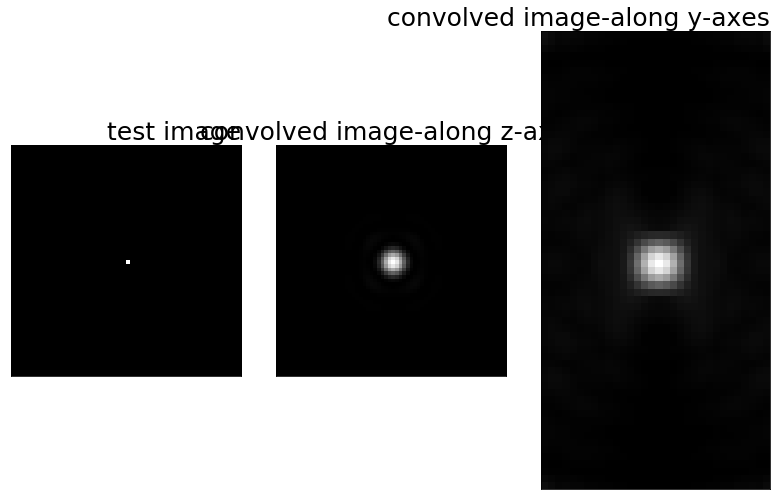

(576, 864, 3)

In [53]:
f = plt.figure(figsize=(12,8))

plt.subplot(131); 
temp = plt.imshow(myobject[:,:,m_d], cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('test image', fontsize=25, loc='right');
plt.subplot(132); 
temp = plt.imshow(myobject_conv[:,:,m_d], cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('convolved image-along z-axes', fontsize=25)
plt.subplot(133); 
temp = plt.imshow(np.max(myobject_conv, axis=0), cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('convolved image-along y-axes', fontsize=25, loc='right')

plt.subplots_adjust(left=0.02, wspace=0.15, top=0.92)
plt.show()

# If we haven't already shown or saved the plot, then we need to
# draw the figure first...
f.canvas.draw()

# Now we can save it to a numpy array.
data = np.fromstring(f.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(f.canvas.get_width_height()[::-1] + (3,))
data.shape

In [131]:
a,b = tf.Session().run([tf.constant([1,2,3]), tf.constant([4,5,6])])
print(a,b)

[1 2 3] [4 5 6]


In [17]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2801656681870403299, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6681632440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 929224753502256188
 physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [30]:
print((otf.shape+(1,)))

(64, 64, 32, 1)


In [7]:
import cv2 

imgG = cv2.imread('GeneratorO.png', 0)
imgI = cv2.imread('iterationModel.png', 0)
# imgI.shape

f = plt.figure(figsize=(12,8))

plt.subplot(121); 
temp = plt.imshow(myobject[:,:,m_d], cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('test image', fontsize=25, loc='right');
plt.subplot(122); 
temp = plt.imshow(myobject_conv[:,:,m_d], cmap='gray'); 
plt.xticks([]); plt.yticks([]); plt.title('convolved image-along z-axes', fontsize=25)

plt.subplots_adjust(left=0.02, wspace=0.15, top=0.92)
plt.show()

(408, 387)